In [1]:
############# OPEN A TERMINAL AND OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

##### THEN CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru

In [1]:
library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(exactextractr)

library(ggplot2)
library(viridis)
library(sn)

Warning message:
“package ‘INLA’ was built under R version 4.3.2”
Loading required package: sp

This is INLA_24.02.09 built 2024-02-09 03:35:28 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Linking to GEOS 3.12.0, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

terra 1.7.55


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: viridisLite

Loading required package: stats4


Attaching package: ‘sn’


The following 

#################### Model-assisted vs model-based ###########

From McRoberts et at (2022): With model-based inference each population unit is assumed to have an entire distribution of possible values as opposed to design-based inference, for which each population unit is assumed to have one and only one possible value. Standard model-based terminology specifies use of the verb “to predict” when referring to random variables and “to estimate” when referring to fixed value parameters. Model-based inferences do not require probability samples, although they can be used, and in many instances may be preferable.


#################### Geostatistical Model-based Estimation ###

'Geostatistical' typically means a spatial model that utilized point-referenced data: every data point is associated with a particular location, rather than an area, for instance.

Our target variable at location s (AGBD, here) is assumed to follow the model

\begin{align}
y(s) = (\alpha + \tilde{\alpha}(s)) + (\beta + \tilde{\beta}(s))*x(s) + \epsilon(s)
\end{align}

And, if you wanted to add another covariate (e.g. the CCI as well as a map of GEDI height estimates)

\begin{align}
y(s) = (\alpha + \tilde{\alpha}(s)) + (\beta + \tilde{\beta}(s))*x1(s) + (\eta + \tilde{\eta}(s))*x2(s) + \epsilon(s) 
\end{align}

Most of the values should be familiar. $\alpha$ and $\beta$ are constant regression coefficients. x1 and x2 are our covariates (e.g. the CCI map and the GEDThere spatially-varying versions are now assumed to follow
point-referenced Gaussian processes, which vary continuously with location s.

Modeling with Gaussian processes natively is very computationally expensive
when the number of observations becomes large. We can circumvent this with
the stochastic partial differential equation (SPDE) approach.
This will hopefully become more clear as the demonstation goes on, 
and I have further explanations, but I will give a short overview now.
We first define an underlying "mesh". This draws a graph of triangles across the
study area. On the vertices of triangles, we define a neighbor-based spatial model
(much like the area models before) where two vertices are neighbors if there
is a triangle edge connecting them. To exted this to continuous locations, the
value of the Gaussian process at any location s lying within a triangle is
linearly interpolated from the 3 vertices of the containing triangle!
The reason why this is more computationally effecient is that the
process on the vertices is SPARSE: for any given vertex, it only needs
the information from the connected vertices.

Say we have a mesh with k vertices. Taking $\tilde{\alpha}(s)$ as an example,
we give the representation

\begin{align}
    \tilde{\alpha}(s) = \vec{a}(s)^T \vec{w}_\alpha
\end{align}

where $\vec{w}_\alpha$ is a vector of values at the k vertices. To
interpolate these into any location s, we multiply them by weights
$\vec{a}(s)$ and add everything together. Weights $\vec{a}(s)$ has at most
3 non-zero entries, corresponding to the three vertices of the triangle
containing location s.

-- Residuals on covariates can be skewed as a result of our Gaussian assumption. Let's plot it and check. 
-- Above can maybe resolved by transformation (gamma TLM, log transformation), which can resolve the skew
-- Prediction of AGBD < 0 

-- Kriging is the best linear predictor [weighted average] ...the best weights you could choose to minimize expected error. 
-- Our equations are similar to kriging.. 

-- alpha and beta have their own Matern covariance functions

In [100]:
########################## CLIP THE GEDI L4B MAP TO MEXICO ###################################
if (!file.exists("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/l4b_mexico.tif")) {
v <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON1_DISS.gpkg") %>% st_union() %>% st_transform(crs = 6933)
r <- rast("/projects/my-public-bucket/Data/Biomass_maps/GEDI_L4B_v21/GEDI_v21_MU.tif")
x <- crop(r, vect(v),mask=TRUE)
writeRaster(x,"/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/l4b_mexico.tif",overwrite=TRUE) }

In [101]:
########################## READ THE MEXICAN NFI DATA ###################################
plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/Daso_A_Cgl_C3_V7_24052022_1.gpkg")
loc.plot.WGS84 <- st_coordinates(plot_WGS84)
plot = plot_WGS84 %>% st_transform("epsg:6933")
agbd.plot = plot$AGB_C3
loc.plot = st_coordinates(plot)
n.plot = nrow(loc.plot)
Table <- loc.plot

Reading layer `daso_a_cgl_c3_v7_24052022_1' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/Daso_A_Cgl_C3_V7_24052022_1.gpkg' 
  using driver `GPKG'
Simple feature collection with 10959 features and 8 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -116.8662 ymin: 14.58767 xmax: -86.76697 ymax: 32.542
Geodetic CRS:  WGS 84


In [102]:
length(agbd.plot[agbd.plot == 0])
length(agbd.plot)

[1] 1386

[1] 10959

In [103]:
########################## READ THE NICO LAND FOREST HEIGHT MAPS AND EXTRACT DATA######
dataFiles = list.files('/projects/LANG_FH',pattern="*.tif$", recursive=F, full.names=TRUE)
listOfShp = list()

for(i in 1:length(dataFiles)){
    height.rast <- rast(dataFiles[i]) 
    hei.plot = extract(x = height.rast, y = loc.plot.WGS84)[,1]
    Table = cbind(Table,hei.plot)
}
hei.plot = rowMeans(Table[,3:ncol(Table)], na.rm=TRUE)

In [104]:
length(hei.plot[hei.plot == 0])
length(hei.plot)

[1] 3404

[1] 10959

In [109]:
####################### LOAD THE CCI BIOMASS MAP #######################
cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif")
cci.plot = extract(x = cci.rast, y = loc.plot)[,1] 

# I wanted everything to be in meters, so I projected to
# the EASE grid. Takes a while on my machine...
# cci.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico.tif") %>% project("epsg:6933")
# writeRaster(cci.rast,"/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif",overwrite=TRUE)
glad.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif") ######### 
glad.plot = extract(x = glad.rast, y = loc.plot)[,1] 
# l4b.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/l4b_mexico.tif")

Warning message:
“Removed 70 rows containing missing values (`geom_point()`).”


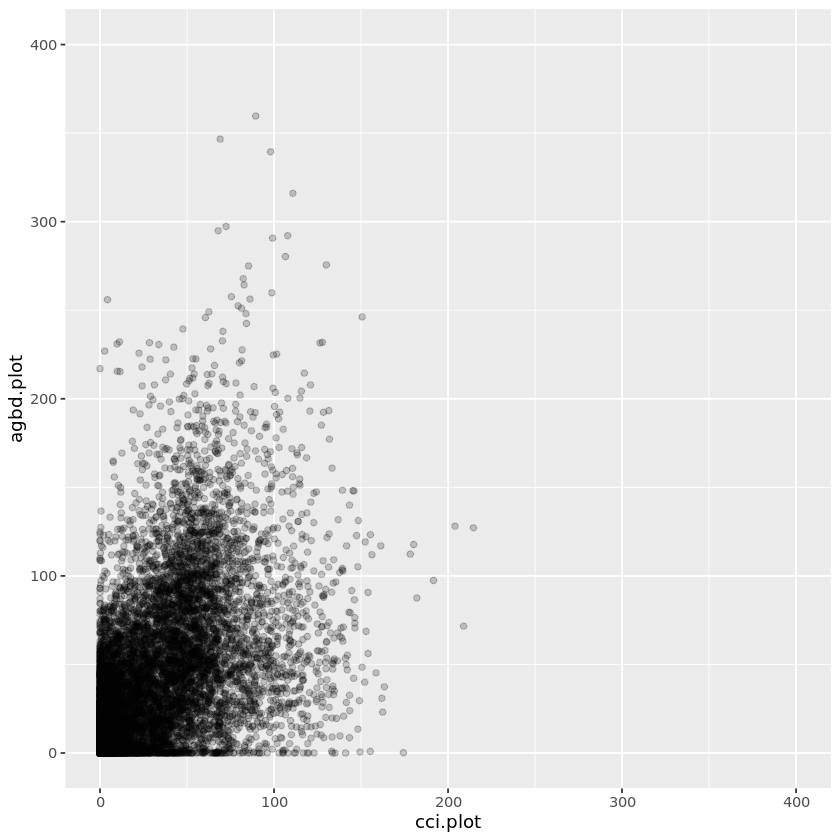


Call:
lm(formula = (agbd.plot) ~ (hei.plot) + (cci.plot), na.action = na.omit)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.860  -2.098  -0.008   1.889  10.060 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.511036   0.039436   63.67   <2e-16 ***
hei.plot    0.182469   0.003227   56.54   <2e-16 ***
cci.plot    0.025571   0.001028   24.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.692 on 10886 degrees of freedom
  (70 observations deleted due to missingness)
Multiple R-squared:  0.457,	Adjusted R-squared:  0.4569 
F-statistic:  4580 on 2 and 10886 DF,  p-value: < 2.2e-16


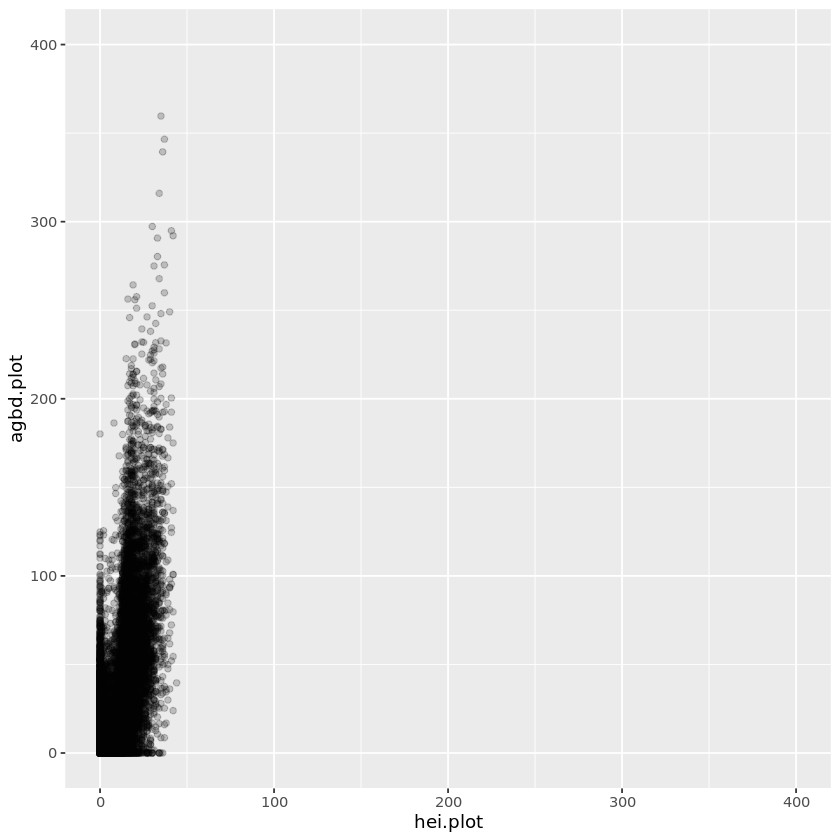

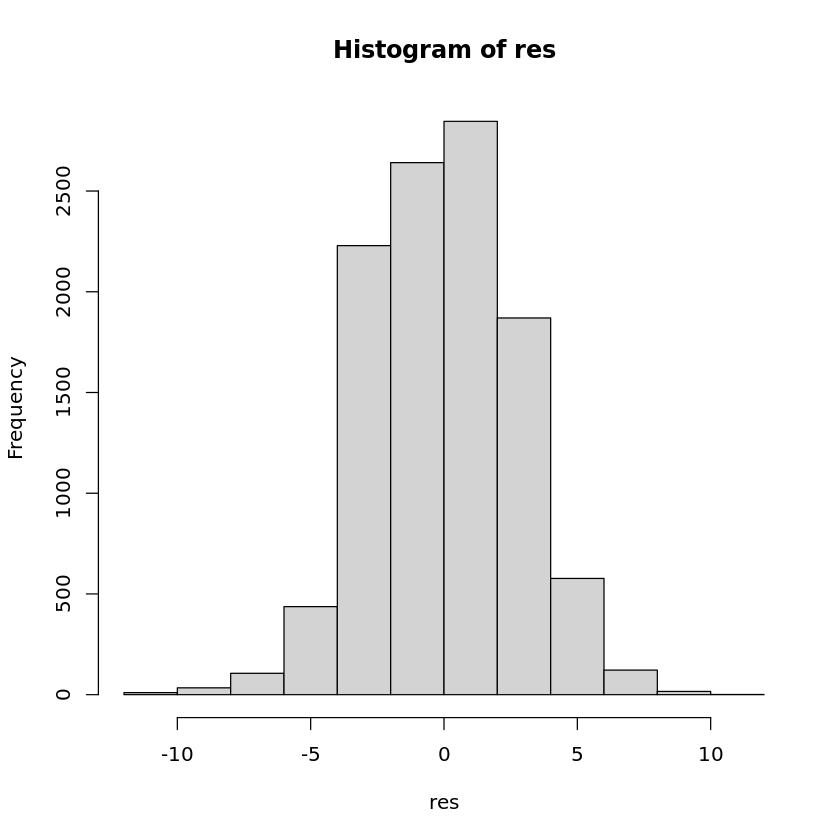

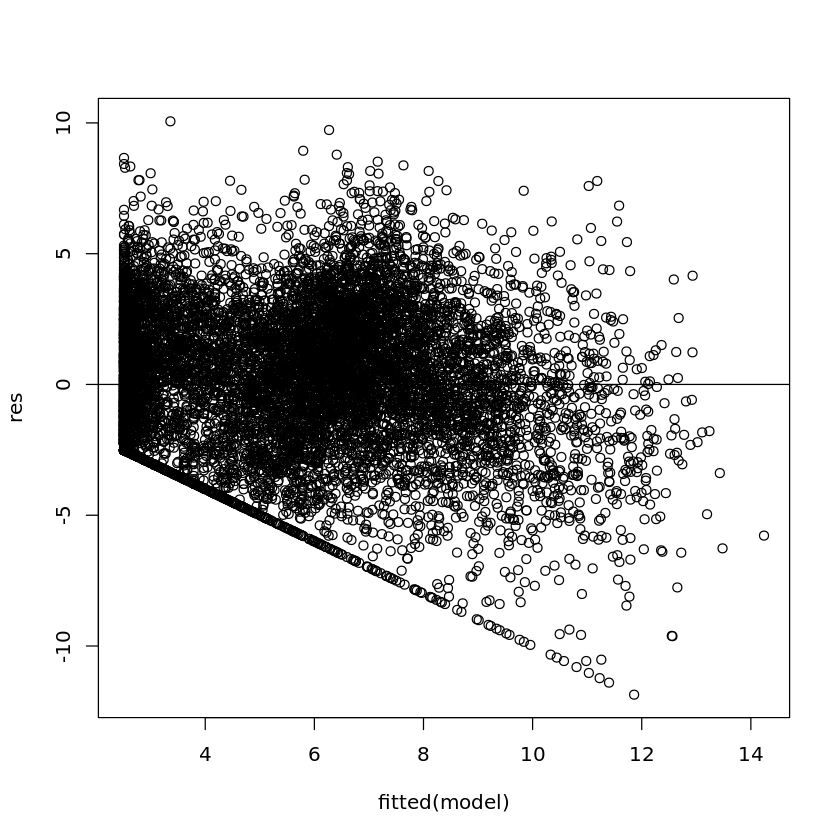

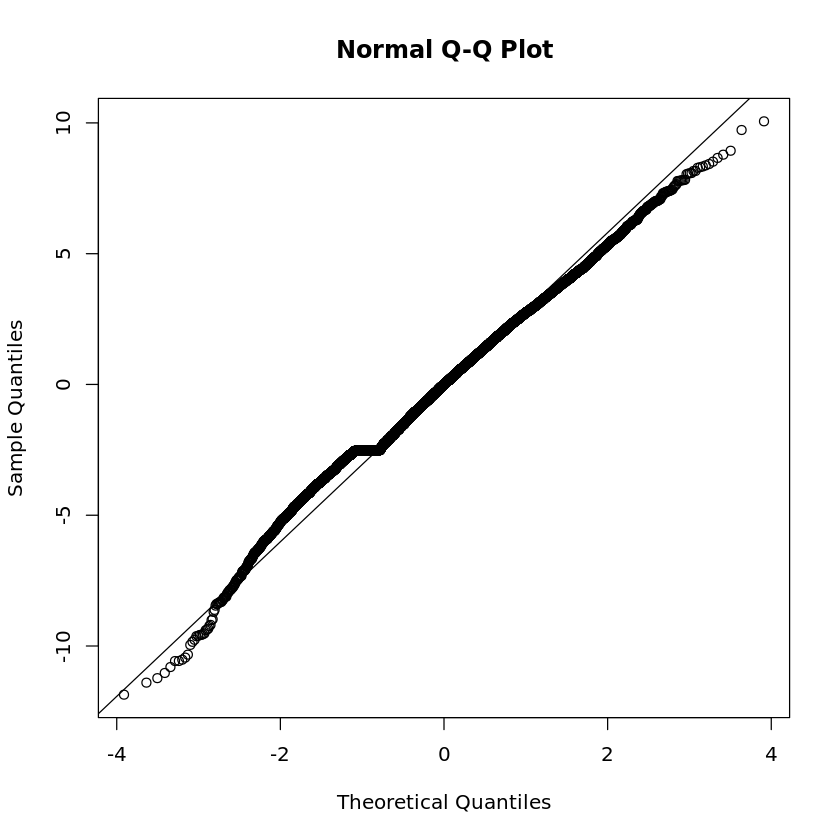

In [106]:
############# RELATION BETWEEN CCI, HEIGHTS AND NFI AT THE PLOT LEVEL ########################

ggplot() + geom_point(aes(x = cci.plot, y = agbd.plot), alpha = 0.2) + xlim(0,400) + ylim(0,400)
ggplot() + geom_point(aes(x = hei.plot, y = agbd.plot), alpha = 0.2) + xlim(0,400) + ylim(0,400)

############### TRANSFORMATION FOR POOR RESIDUALS ############## y.trans = sqrt(plot.agbd)

cci.plot = cci.plot
hei.plot = hei.plot
agbd.plot = sqrt(agbd.plot)

model <- (lm((agbd.plot)~(hei.plot)+(cci.plot), na.action=na.omit))
summary(model)
res <- resid(model)
hist(res)
plot(fitted(model), res)
abline(0,0)
qqnorm(res)
qqline(res)

# DATA <- cbind(cci.plot,hei.plot,agbd.plot)
# write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv",row.names=FALSE)

In [118]:
####################### Let's play with a package called INLA: In essesnce, it makes Bayesian inference faster ############################
# data <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv")
# agbd.plot = data$agbd.plot
# hei.plot = data$hei.plot
# cci.plot = data$cci.plot

lmod <- lm((agbd.plot)~(hei.plot)+(glad.plot)+(cci.plot))
summary(lmod)

lmod2 <- lm((agbd.plot)~(hei.plot)+(glad.plot))
summary(lmod2)

anova(lmod2,lmod)

AIC(lmod)
AIC(lmod2)

BIC(lmod)
BIC(lmod2)


Call:
lm(formula = (agbd.plot) ~ (hei.plot) + (glad.plot) + (cci.plot))

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3585  -1.9300   0.0307   1.8003   9.1719 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.427432   0.037271  65.129  < 2e-16 ***
hei.plot    0.080328   0.004124  19.479  < 2e-16 ***
glad.plot   0.240910   0.006561  36.718  < 2e-16 ***
cci.plot    0.007907   0.001083   7.303 3.02e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.539 on 10885 degrees of freedom
  (70 observations deleted due to missingness)
Multiple R-squared:  0.5168,	Adjusted R-squared:  0.5167 
F-statistic:  3881 on 3 and 10885 DF,  p-value: < 2.2e-16



Call:
lm(formula = (agbd.plot) ~ (hei.plot) + (glad.plot))

Residuals:
     Min       1Q   Median       3Q      Max 
-13.5300  -1.9446   0.0235   1.8198   9.4623 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.470097   0.036899   66.94   <2e-16 ***
hei.plot    0.083766   0.004107   20.40   <2e-16 ***
glad.plot   0.262196   0.005892   44.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.545 on 10886 degrees of freedom
  (70 observations deleted due to missingness)
Multiple R-squared:  0.5144,	Adjusted R-squared:  0.5144 
F-statistic:  5767 on 2 and 10886 DF,  p-value: < 2.2e-16


Res.Df RSS      Df Sum of Sq F        Pr(>F)      
1 10886  70514.86 NA       NA        NA           NA
2 10885  70171.08  1 343.7815  53.32769 3.020209e-13

[1] 51199.84

[1] 51251.06

[1] 51236.32

[1] 51280.24


Call:
lm(formula = (agbd.plot) ~ (hei.plot) * (cci.plot))

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1519  -1.9859  -0.0551   1.7843   9.6241 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.9858782  0.0438916   45.24   <2e-16 ***
hei.plot           0.2396677  0.0039044   61.38   <2e-16 ***
cci.plot           0.0544734  0.0015411   35.35   <2e-16 ***
hei.plot:cci.plot -0.0018176  0.0000737  -24.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.619 on 10885 degrees of freedom
  (70 observations deleted due to missingness)
Multiple R-squared:  0.4857,	Adjusted R-squared:  0.4856 
F-statistic:  3427 on 3 and 10885 DF,  p-value: < 2.2e-16



Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

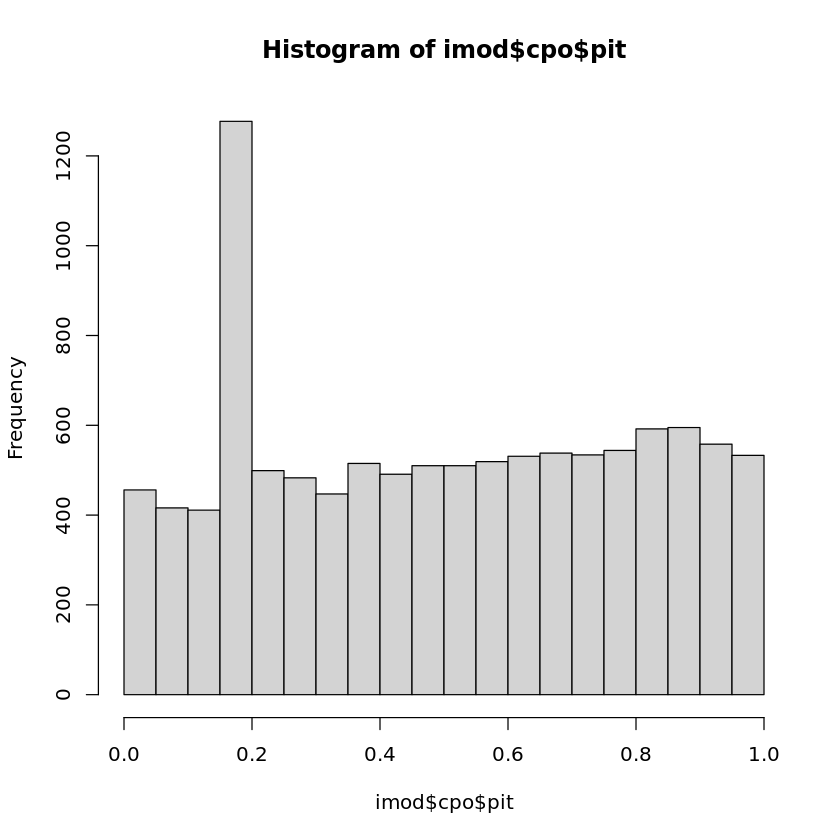

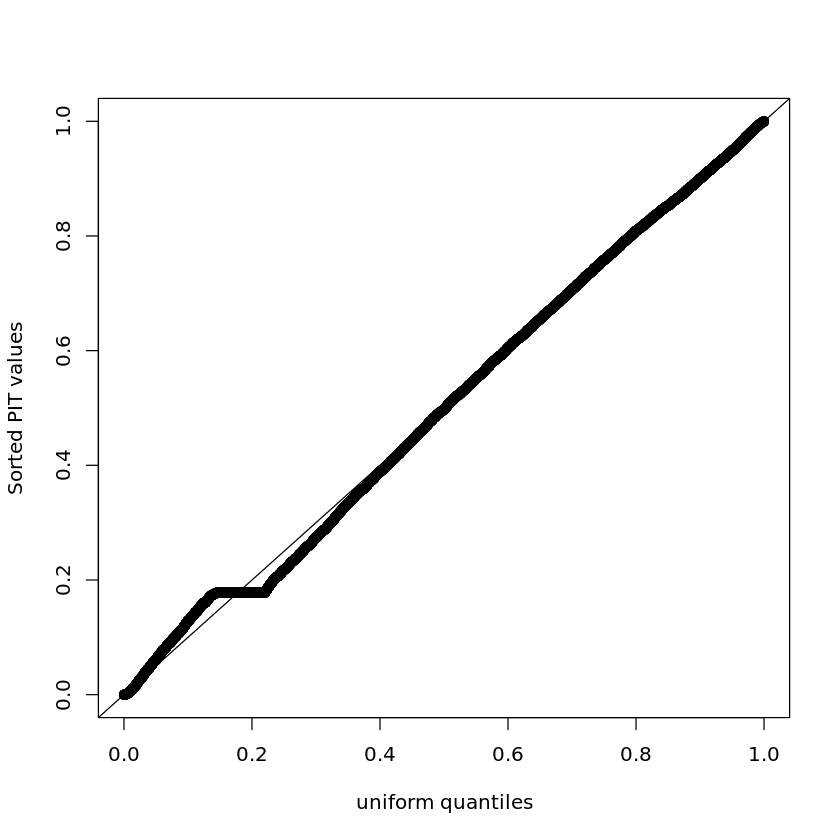

In [88]:
formula = (agbd.plot)~(hei.plot)+(cci.plot)
imod <- inla(formula,data=data, family="gaussian", ,control.compute=list(config = T, dic = T, waic = T, cpo=TRUE))
summary(imod)

n = nrow(data)
hist(imod$cpo$pit)
uniquant <- (1:n)/(n+1)
plot(uniquant, sort(imod$cpo$pit), xlab="uniform quantiles", ylab="Sorted PIT values")
abline(0,1)

Reading layer `ecort08gw_DESECON1_DISS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON1_DISS.gpkg' 
  using driver `GPKG'
Simple feature collection with 7 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.366 ymin: 14.53399 xmax: -86.71074 ymax: 32.7174
Geodetic CRS:  WGS 84


[1] 16094

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“Removed 89381 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1021 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1308 rows containing missing values (`geom_segment()`).”


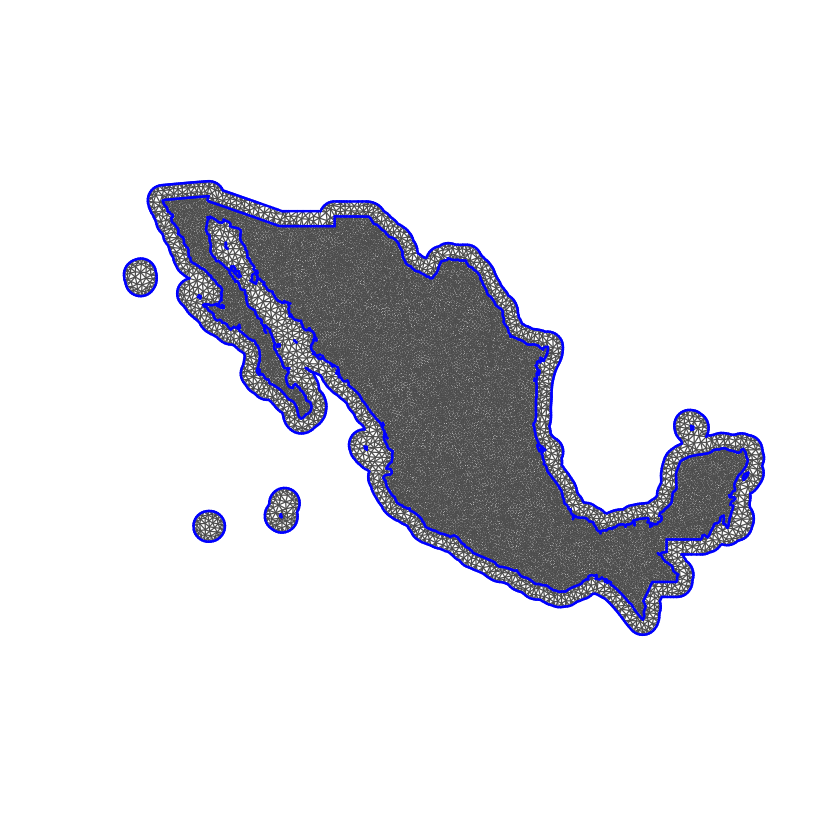

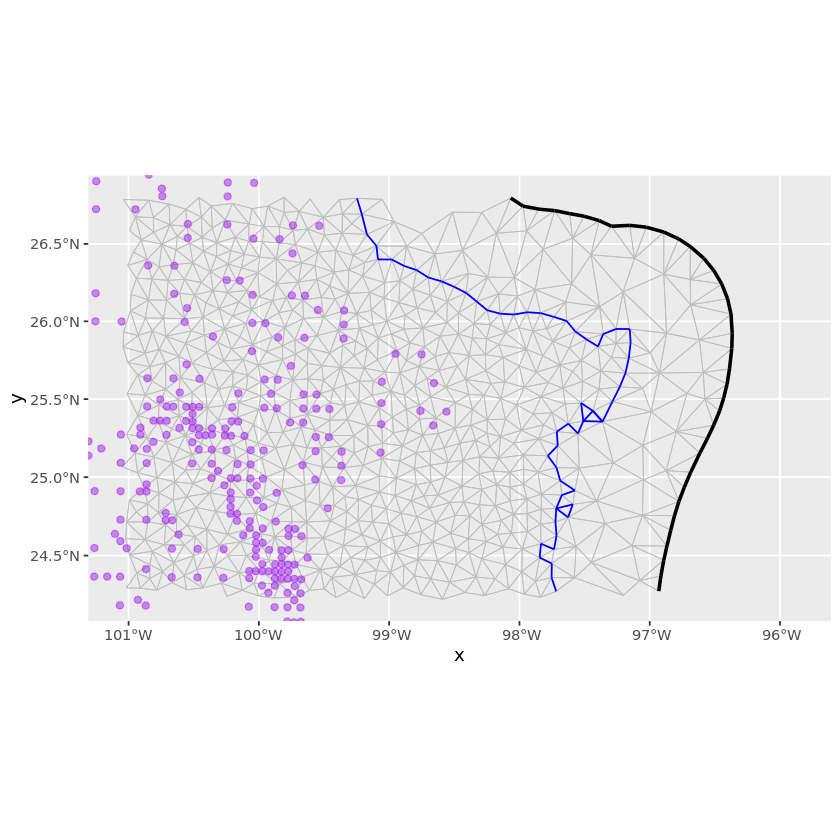

In [7]:
############################### READ: https://rpubs.com/jafet089/886687 : GIVES INFORMATION ON BUILDING A MESH ######################

# I'm loading the areas and merging them into one mexico shapefile
mexico = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON1_DISS.gpkg") %>% st_union() %>% st_transform(crs = 6933)

# Okay, this is the most complicated extra bit of the geostatistical model.
# We are going to model the Gaussian processes with the 
# stochastic partial differential equation (SPDE) approach.

# In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), 
# such that every finite collection of those random variables has a multivariate normal distribution. 

# A Gaussian process is the solution to a stochastic differential equation.

# A stochastic differential equation (SDE) is a differential equation in which one or more of the terms is a 
# stochastic process,[1] resulting in a solution which is also a stochastic process.

# Instead of using the solution directly, we can use a finite element approximation (FEM, very common in engineering) to represent the solution.

# The description of the laws of physics for space- and time-dependent problems are usually expressed in 
# terms of partial differential equations (PDEs). For the vast majority of geometries and problems, these PDEs cannot 
# be solved with analytical methods. Instead, an approximation of the equations can be constructed, typically based upon 
# different types of discretizations. These discretization methods approximate the PDEs with numerical model equations, 
# which can be solved using numerical methods. The solution to the numerical model equations are, in turn, an approximation 
# of the real solution to the PDEs. The finite element method (FEM) is used to compute such approximations.

# The mesh partitions our study are into triangles. These triangles are the finite elements. A neighbor-based spatial model is defined on the triangle vertices.
# Then, for all values within the triangles, the spatial process is linearly interpolated from the vertices.
# The finer the mesh (to an extent), the better the approximation to the full Gaussian process. But the finer the mesh, the more computationally expensive
# the model fitting will be. It's important that the max triangle edge length (more later) is at most 1/3 of the spatial range that you estimate (but this 
# spatial range, you don't know yet...lets find out once the model is run). Usually this entails a couple rounds of model fitting.

################################### NOTES ##########################################################
# loc	Matrix of point locations to be used as initial triangulation nodes.
# loc.domain	Matrix of point locations used to determine the domain extent.
# offset	The automatic extension distance. One or two values, for an inner and an optional outer extension. The amount in which the domain should be 
# extended in the inner and outer part can be controlled with the offset argument of the inla.mesh.2d function. 
## Lindgren and Rue (2015), suggest for the domain to be extended by a distance at least equal to the range to avoid the boundary effect. The amount in 
# which the domain should be extended in the inner and outer part can be controlled with the offset argument of the inla.mesh.2d function. 
# For this example we will expand the inner layer by the same amount as the max.edge and the outer layer by 5*max.edge.
# n	The number of initial nodes in the automatic extensions (default=16)
# boundary	A list of one or two inla.mesh.segment objects describing domain boundaries.
# interior	An inla.mesh.segment object describing desired interior edges.
# max.edge	The largest allowed triangle edge length. One or two values.
# min.angle	The smallest allowed triangle angle. One or two values. (Default=21)
# cutoff	Another potential problem we need to sort out occurs when the nodes in the mesh are too close to each other. This can happen because the mesh tries to put one node at each location supplied in loc argument. 
# When species occurrences in this case, are recorded at locations are very close to each other, a mesh with a large number of vertices will be created at the location where species occur. We can change the cutoff value to avoid building too 
# many small triangles around clustered data points. The cutoff value is shortest allowed distance between points because points with a distance less than the cutoff will be considered a single vertex. 
# For this example, I will replace points with distance less than 1 km by a single vertex. In practice, some authors have suggested to begin with a cutoff equal to 1/5 of the max.edge value of the inner domain and make adjustments as necessary.
################################### NOTES ##########################################################

# Max edge of 15 kilometers, to start
max.edge = 15*10^3 ######## originally:  15*10^3

# We need a buffer on the domain to prevent boundary effects from the differential equation boundary conditions...
mexico.buffer = st_buffer(mexico, dist = max.edge*5)

mesh = inla.mesh.2d(boundary = list(as(mexico, "Spatial"), as(mexico.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge))

# This is the resulting number of vertices. It's the ultimate determinant of computational expense
k = mesh$n
k

# # This is what the mesh looks like
plot(mesh)                 

# Let's zoom in to a corner, so you can see what the mesh and buffer looks like
ggplot() + inlabru::gg(data = mesh) + coord_sf(crs = 6933) + geom_sf(data = plot,col='purple',size=1.7,alpha=0.5) + xlim(-9.75*10^6, -9.25*10^6) + ylim(3*10^6, 3.3*10^6) 

The following cell constructs a Matern SPDE model, with spatial range $\rho$ and standard deviation parameter $\sigma$. In the parameterisation

\begin{align}
(\kappa^2-\Delta)^{(\alpha/2)} (\tau x(u)) = W(u)
\end{align}

the spatial scale parameter κ=√{8ν}/ρ, where ν=α-d/2, and τ is proportional to 1/$\sigma$.

In [8]:
# We need to put priors on the Gaussian process sd and range parameters. We are using the penalized complexity (PC) priors. They operate by putting 
# prior probability bound on the data.
# matern is covraince function, compare it to the exponential covariance function 

# Priors for the varying intercept
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5))

# # Priors for the varying coefficient
# spde.theta = inla.spde2.pcmatern(mesh, 
#                                 prior.range = c(30*10^3, 0.01), # Same interpretations here
#                                 prior.sigma = c(1, 0.5))

# Priors for the varying coefficient
spde.eta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5))

# This is the mesh projection matrix that interpolates the vertices to the plot locations.
# Each row interpolates each observation. So the ith row is the vector of weights that
# interpolates the vertices to the ith location. Results in an n x k matrix.
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot)
dim(A.plot) ### gives you number of rows (9955 NFI plots) x number of columns (number of vertices)

# formula
formula = agbd ~
  -1 + 
  intercept + 
  cci +
  # l4b +
  hei +
  f(alpha.spat, model = spde.alpha) + #... plus a spde for the spatial alpha
  f(beta.spat, model = spde.beta) +
  # f(theta.spat, model = spde.theta) +
  f(eta.spat, model = spde.eta)

# stack
stack = inla.stack(data = list(agbd = agbd.plot),
                   A = list(1,
                            1,
                            1,
                            # 1,
                            A.plot,
                            Diagonal(x = cci.plot)%*%A.plot,
                            # Diagonal(x = l4b.plot)%*%A.plot,
                            Diagonal(x = hei.plot)%*%A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     cci = cci.plot,
                     # l4b = l4b.plot,
                     hei = hei.plot,
                     alpha.spat = 1:k, # The random effects just need to given unique indices.
                     beta.spat = 1:k, # The random effects just need to given unique indices.
                     # theta.spat = 1:k,
                     eta.spat = 1:k
                   ))

[1] 10959 16094

[1] -24181.91


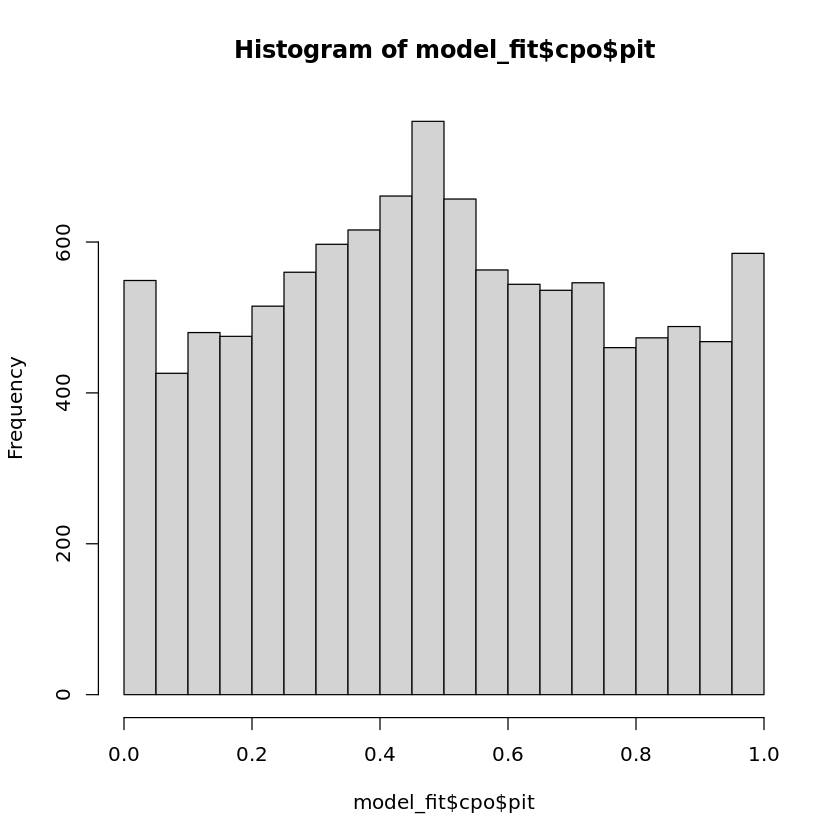

In [68]:
# Fit this thing, its takes a while (an hour on my laptop).
# I saved my model fit so you can just load it and start messing around

# model_fit = inla(formula = formula, # Provide the formula
#                  family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
#                  data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
#                  control.predictor = list(A = inla.stack.A(stack)),
#                  control.compute = list(config = T, dic = T, waic = T, cpo = T ), ### , cpo = T : compute the sum(log(model_fit$cpo$cpo)) and you want this value to be HIGHER, conditional predictive ordinates
#                  control.inla = list(int.strategy = "eb"),
#                  verbose = T)
# summary(model_fit)

load("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Mexico/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20)
print(sum(log(model_fit$cpo$cpo)))
# save(model_fit, file = "/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Mexico/INLA_model_fit.RData")

# load("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Mexico/INLA_model_fit.RData")

# returns the model parameters.
# One thing to notice is that our expected ranges are ~20 km.
# Our max triangle edge length was 15 km, so not much smaller....
# We almost certainly want to reiterate with a finer mesh,
# but for now we will carry on.

#########  conditional predictive ordinates = leave one out cross validation...whats the density of my posterior distribution at the true value after removing each value. 

# conditional predictive ordinates (CPO)
# That computes the cross-validated Probability Integral Transforms (PIT). That
# 's the true Bayesian way to check the shape of your "residuals" and make sure
# the model is well-specified. We'll talk more about what those mean soon.
# Essentially, you want hist(model_fit$cpo$pit)  to be approximately uniform distributed.

# BELOW: 
# Range for alpha.spat and Stdev for alpha.spat are parameters of the Matern covariance function 
# alpha tilda is a Gaussian process, and it has a covaraince function, and I'm getting sigma and rho (range) 
# same for beta, but it's being mutipled by x, which is our CCI values. 

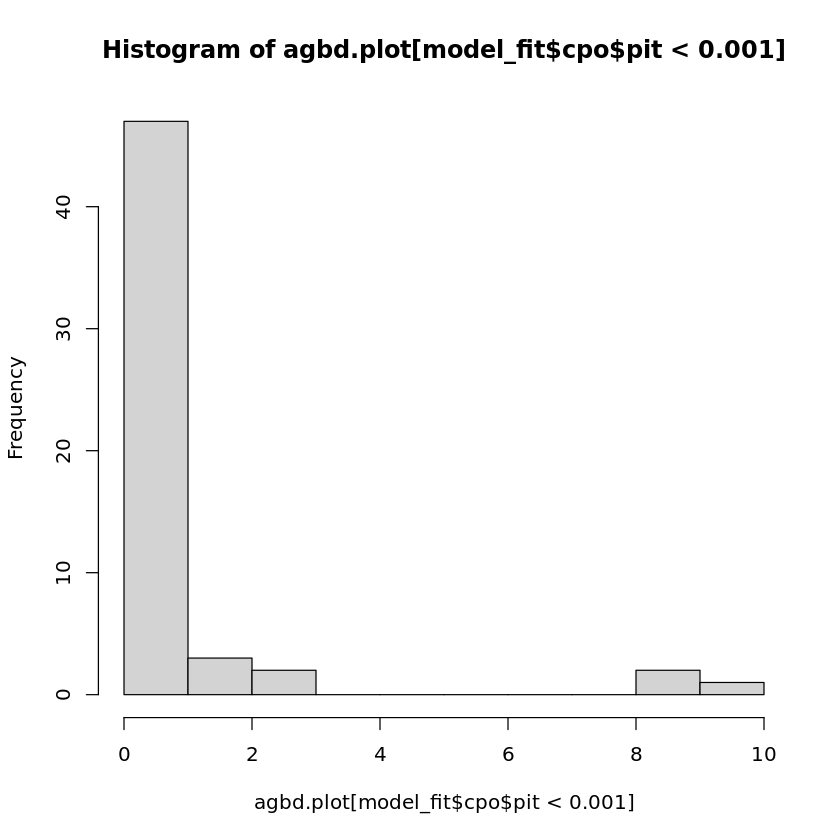

In [69]:
hist(agbd.plot[model_fit$cpo$pit < 0.001]) # shows me which nfi plots are causing those odd tails in the hist of cpo

In [12]:
samples = inla.posterior.sample(n = 250, result = model_fit,
                                selection = list(intercept = 1, # Only one intercept term
                                                 cci = 1, # Only one regression coefficient
                                                 hei = 1,
                                                 alpha.spat = 1:k, # we want to sample at all k mesh nodes
                                                 beta.spat = 1:k,
                                                 eta.spat = 1:k)) # same as above

In [14]:
samples[1]

[[1]]
[[1]]$hyperpar
Precision for the Gaussian observations                    Range for alpha.spat 
                           2.307931e-01                            3.567696e+05 
                   Stdev for alpha.spat                     Range for beta.spat 
                           1.402272e+00                            9.857248e+04 
                    Stdev for beta.spat                      Range for eta.spat 
                           2.588860e-02                            2.103368e+05 
                     Stdev for eta.spat 
                           9.425629e-02 

[[1]]$latent
                          [,1]
alpha.spat:1     -2.375224e+00
alpha.spat:2     -2.584157e+00
alpha.spat:3     -2.642491e+00
alpha.spat:4     -2.154493e+00
alpha.spat:5     -2.385752e+00
alpha.spat:6     -2.242060e+00
alpha.spat:7     -1.828162e+00
alpha.spat:8     -1.724186e+00
alpha.spat:9     -1.265135e+00
alpha.spat:10    -9.814438e-01
alpha.spat:11    -7.596235e-01
alpha.spat:12    -7.283595e-01
alpha.spat:13    -4.235459e-01
alpha.spat:14     7.224033e-02
alpha.spat:15     4.528926e-01
alpha.spat:16     7.955722e-01
alpha.spat:17     1.091205e+00
alpha.spat:18     1.462291e+00
alpha.spat:19     1.243676e+00
alpha.spat:20     8.417234e-01
alpha.spat:21     8.795525e-01
alpha.spat:22     6.373096e-01
alpha.spat:23     8.443601e-01
alpha.spat:24     9.534351e-01
alpha.spat:25     9.081938e-01
alpha.spat:26     1.219198e+00
alpha.spat:27     1.313984e+00
alpha.spat:28     1.327412e+00
alpha.spat:29     4.360000e-01
alpha.spat:30    -3.972537e-02
alpha.spat:31    -1.213448e-01
alpha.spat:32     2.535723e-01
alpha.spat:33     2.792241e-01
alpha.spat:34     2.877821e-01
alpha.spat:35     1.272958e-01
alpha.spat:36    -6.135630e-02
alpha.spat:37     3.097659e-01
alpha.spat:38     4.125635e-01
alpha.spat:39     4.616912e-01
alpha.spat:40     2.163387e-01
alpha.spat:41     1.704482e-01
alpha.spat:42     3.976578e-01
alpha.spat:43     3.872652e-01
alpha.spat:44     3.581948e-01
alpha.spat:45     1.893420e-01
alpha.spat:46     4.777719e-01
alpha.spat:47     5.549672e-01
alpha.spat:48     6.580074e-01
alpha.spat:49     9.464930e-01
alpha.spat:50     4.575713e-01
alpha.spat:51     2.123639e-01
alpha.spat:52     2.481515e-01
alpha.spat:53     1.341748e-01
alpha.spat:54    -2.650529e-01
alpha.spat:55    -2.834406e-01
alpha.spat:56    -8.678264e-02
alpha.spat:57     4.399687e-01
alpha.spat:58     6.361878e-01
alpha.spat:59     8.421506e-01
alpha.spat:60     2.017990e+00
alpha.spat:61     1.931633e+00
alpha.spat:62     2.236889e+00
alpha.spat:63     2.162402e+00
alpha.spat:64     2.472559e+00
alpha.spat:65     2.755922e+00
alpha.spat:66     3.123983e+00
alpha.spat:67     3.488217e+00
alpha.spat:68     3.353584e+00
alpha.spat:69     2.345178e+00
alpha.spat:70     2.109459e+00
alpha.spat:71     1.541607e+00
alpha.spat:72     1.747906e+00
alpha.spat:73     1.297193e+00
alpha.spat:74     1.107254e+00
alpha.spat:75     1.005122e+00
alpha.spat:76     6.970241e-01
alpha.spat:77     2.857519e-01
alpha.spat:78     3.418764e-01
alpha.spat:79     2.871404e-02
alpha.spat:80    -1.013109e-01
alpha.spat:81    -2.726310e-02
alpha.spat:82     2.458346e-01
alpha.spat:83     3.970535e-01
alpha.spat:84     2.261839e-01
alpha.spat:85    -1.751381e+00
alpha.spat:86    -1.699216e+00
alpha.spat:87    -1.506979e+00
alpha.spat:88    -1.672570e+00
alpha.spat:89    -1.409910e+00
alpha.spat:90    -1.653249e+00
alpha.spat:91    -2.010076e+00
alpha.spat:92    -2.169097e+00
alpha.spat:93    -2.302180e+00
alpha.spat:94    -2.283113e+00
alpha.spat:95    -2.757274e+00
alpha.spat:96    -2.636343e+00
alpha.spat:97    -2.168478e+00
alpha.spat:98    -2.057138e+00
alpha.spat:99    -1.925808e+00
alpha.spat:100   -1.807981e+00
alpha.spat:101   -1.532726e+00
alpha.spat:102   -1.535897e+00
alpha.spat:103   -1.428551e+00
alpha.spat:104   -8.146684e-01
alpha.spat:105   -3.655732e-01
alpha.spat:106   -5.418080e-01
alpha.spat:107   -7.201156e-01
alpha.spat:108   -1.263364e+00
alpha.spat:109   -

Reading layer `ecort08gw_DESECON4_DISS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON4_DISS.gpkg' 
  using driver `GPKG'
Simple feature collection with 101 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.366 ymin: 14.53399 xmax: -86.71074 ymax: 32.7174
Geodetic CRS:  WGS 84


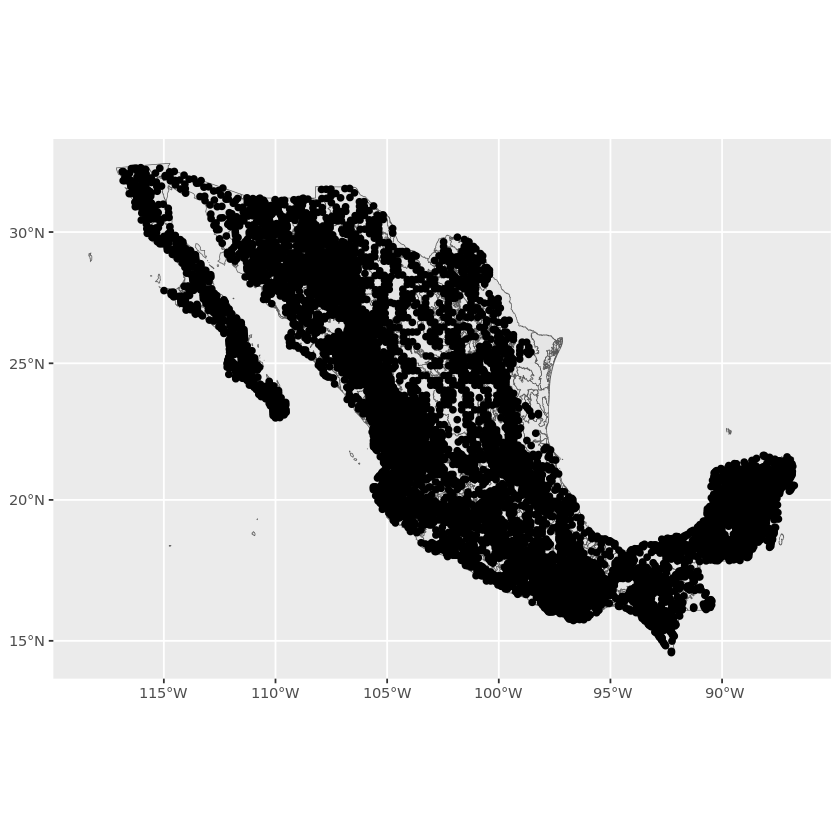

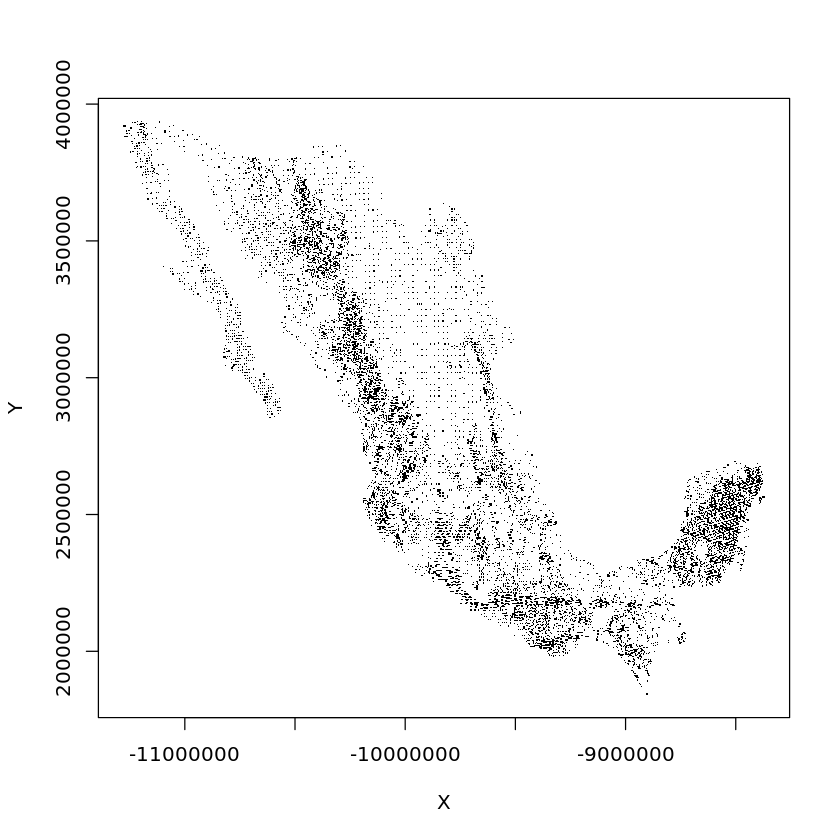

In [70]:
##################################
# Prediction example
##################################

# Let's get a test region to make a prediction for
MU = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON4_DISS.gpkg") %>%st_transform(crs = 6933)

currentMU = MU   #[25,]
# currentMU$DESECON4

currentPlots = st_filter(plot, currentMU)

# Pretty far away from a random sample...
ggplot() + geom_sf(data = currentMU) + geom_sf(data = currentPlots) 


# To make predictions for an area, we first make a grid of point-level predictions. We can then collapse them into a prediction for the whole area.
# In general, it's good for your grid to be dense relative to the area you are predicting over, with a minimum resolution of the plot area,
# i.e., you are predicting side by side plots

# ########### THIS IS IF YOU WANT TO MAKE A WHOLE MAP 
# grid_to_predict = st_make_grid(currentMU, cellsize = c(5000,5000), what = "centers") %>% st_as_sf() %>% st_filter(currentMU) 
# grid = grid_to_predict %>% st_coordinates()
# grid_WGS84 = grid_to_predict %>% st_transform(crs = 4326) %>% st_coordinates()
# plot(grid, pch = '.')

##### HOWEVER, IN CASE I WANTED TO PREDICT EXACTLY WHERE MY NFI PLOTS ARE LOCATED #################
grid_to_predict = st_filter(plot, currentMU)
grid = grid_to_predict %>% st_coordinates()
grid_WGS84 = grid_to_predict %>% st_transform(crs = 4326) %>% st_coordinates()
plot(grid, pch = '.')

In [71]:
# We'll need our covariate values at the grid locations- This takes a bit longer since we have heights in 10 m res as WGS84

cci.pred = extract(cci.rast, grid)[,1]
# l4b.pred = extract(l4b.rast, grid)[,1]
# hei.pred = hei.plot#extract(hei.rast, grid)[,1]

Table <- grid 
dataFiles = list.files('/projects/LANG_FH',pattern="*.tif$", recursive=F, full.names=TRUE)
for(i in 1:length(dataFiles)){
    height.rast <- rast(dataFiles[i]) 
    hei.pred = extract(x = height.rast, y = grid_WGS84)[,1]
    Table = cbind(Table,hei.pred)
}
hei.pred = rowMeans(Table[,3:ncol(Table)], na.rm=TRUE)

In [76]:
# # Our projection matrix for the grid locations
A.pred = inla.spde.make.A(mesh = mesh, loc = grid)
# plot(A.pred)

# # Draw posterior samples from the model. We can use the 'selection = ' option to limit the sampler to the parameters/effects we actually need for prediction. You also give the indices for 
# # each of the parameters/effects, in case you only need some indices of particular parameter/effect

# # 250 RANDOM DRAWS FROM THE POSTERIOR DISTRIBUTION 
samples = inla.posterior.sample(n = 1000, result = model_fit)

# # Our prediction equation. Essentially just the model, but we omit the random error, as it will not matter as we aggregate over moderate-to-large areas.
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    # l4b.pred*l4b +
    hei.pred*hei +
    A.pred%*%alpha.spat[1:mesh$n] +  #### THIS IS POSTERIOR DISTRIBUTION OF ALPHA-TILDE. THE MATRIX A.PRED INTERPOLATES THE MESH NODES TO ANY LOCATION I WANT TO PREDICT AT. 
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:mesh$n] +
    # Diagonal(x = l4b.pred)%*%A.pred%*%theta.spat[1:mesh$n] + 
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:mesh$n]) #### BETA.SPAT IS POSTERIOR DISTRIBUTION OF BETA-TILDE.
}

# ####### if you wanted just alpha tilde
# pred_fun = function(...){
#   drop(intercept + 
#     A.pred%*%alpha.spat[1:mesh$n])  #### THIS IS POSTERIOR DISTRIBUTION OF ALPHA-TILDE. THE MATRIX A.PRED INTERPOLATES THE MESH NODES TO ANY LOCATION I WANT TO PREDICT AT. 
# }
       
# ######## if I wanted just beta + beta-tilde
# pred_fun = function(...){
#   drop(cci + 
#        A.pred%*%beta.spat[1:mesh$n])
# }

# Generate prediction samples
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples))

# Model expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^2)
pred.sd = apply(pred.samples^2, 1, sd)

In [73]:
hist((pred.samples[10,])^2)

ERROR: Error in hist.default(pred.samples[10, ]^2): invalid number of 'breaks'


Warning message:
“Removed 10892 rows containing missing values (`geom_point()`).”


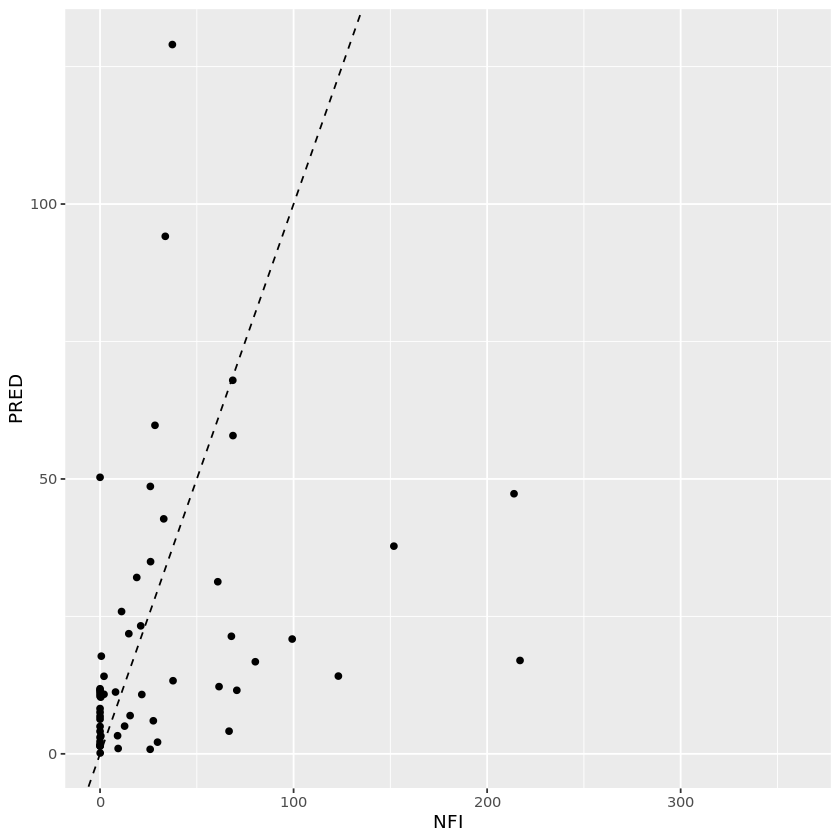

ERROR: Error in qqnorm(OUTPUT$RES) + qqline(OUTPUT$RES): non-numeric argument to binary operator


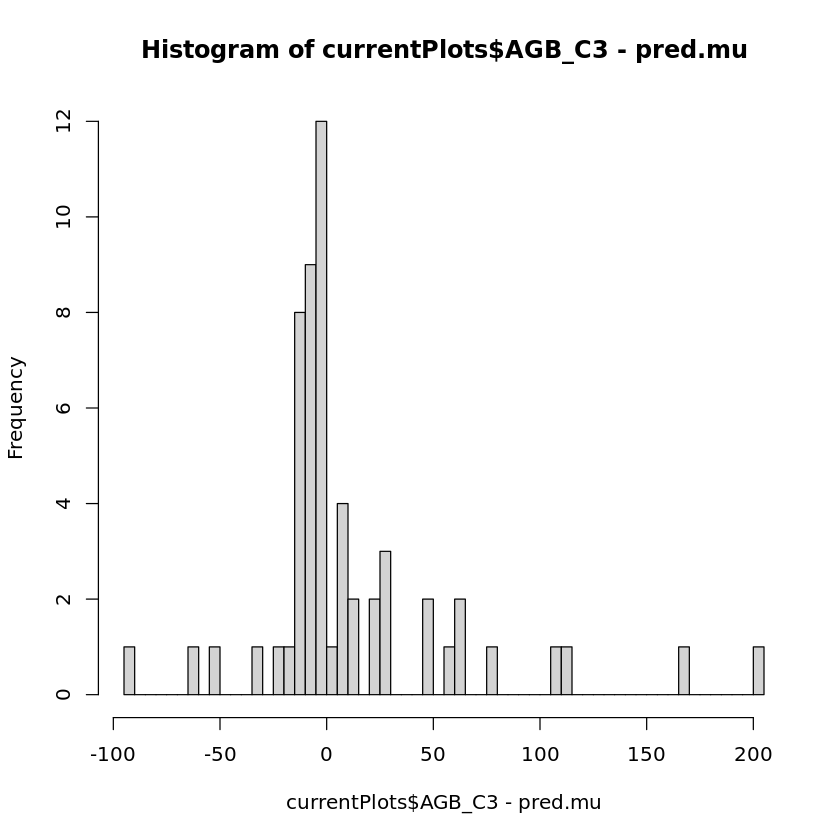

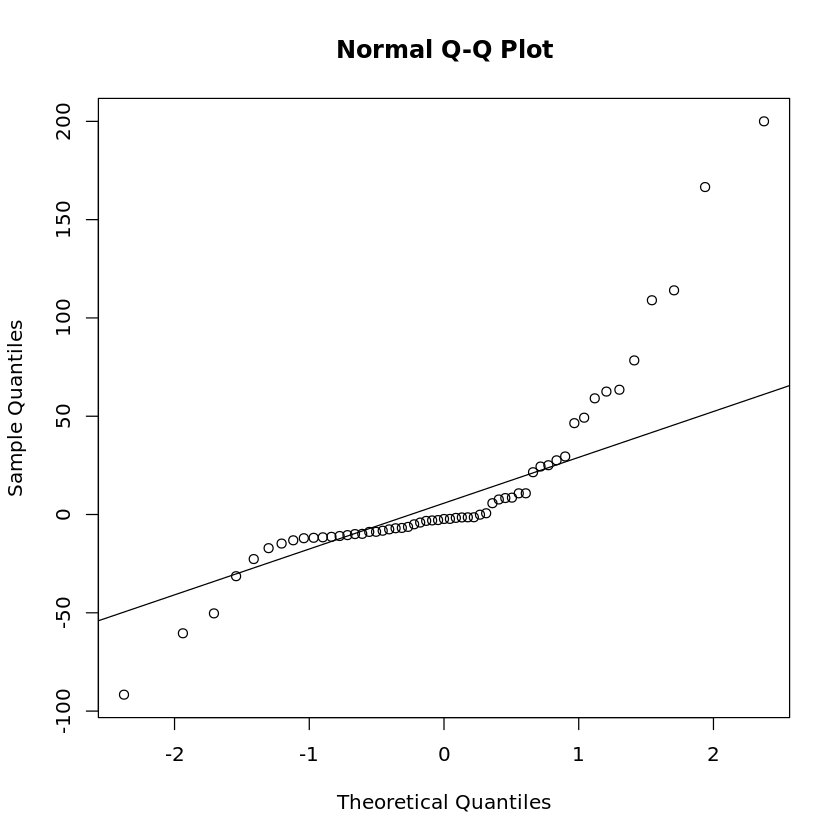

In [77]:
######################## these are the plot-level predictions #####################
OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=(currentPlots$AGB_C3), PRED.SD=pred.sd, RES=currentPlots$AGB_C3-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2) 
hist(currentPlots$AGB_C3-pred.mu,, breaks = 50)
qqnorm(OUTPUT$RES) + qqline(OUTPUT$RES)

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


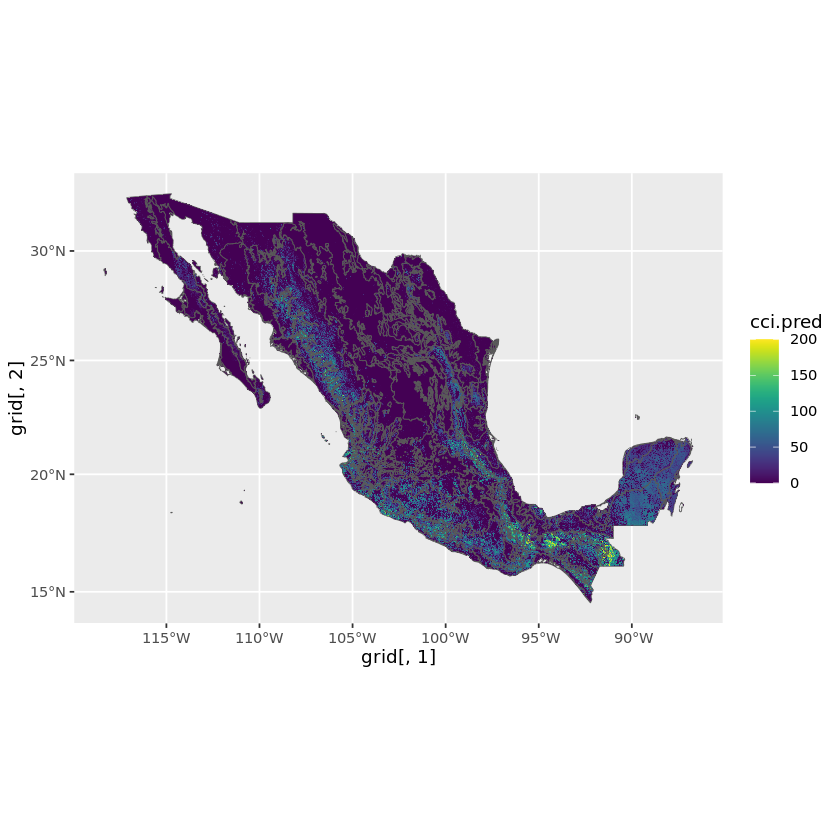

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


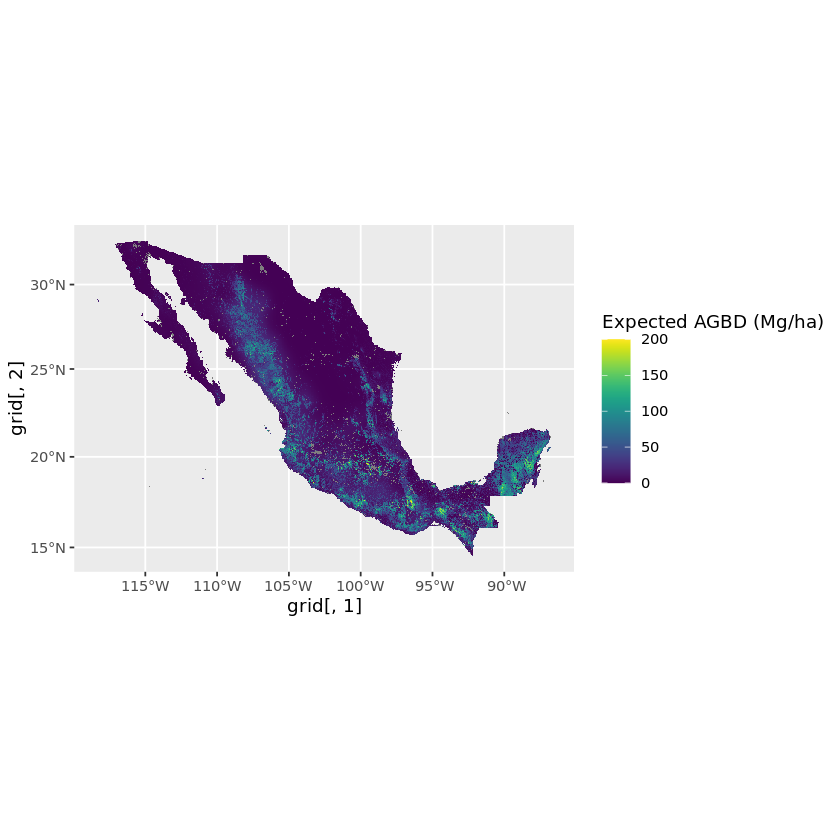

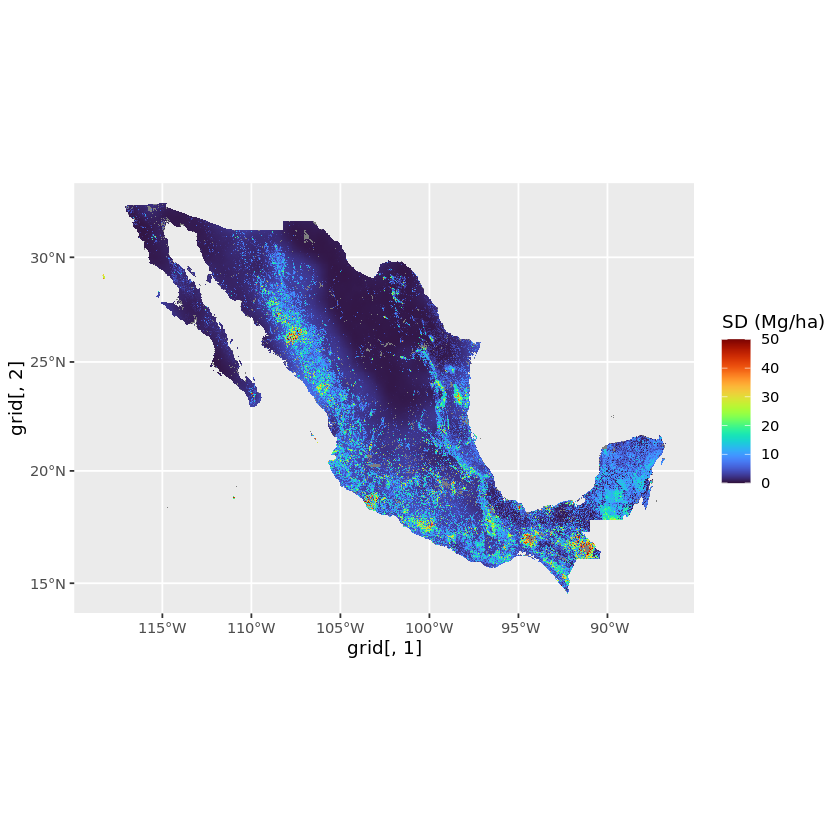

In [18]:
##################### these are the maps when predicting over a grid ################
# The plots over the cci grid values...
ggplot() + 
  geom_raster(aes(x = grid[,1], y = grid[,2], fill = cci.pred)) +
  geom_sf(data = currentMU, fill = NA) + #geom_sf(data = currentPlots, aes(col = "Plots")) +
  scale_fill_viridis(limits = c(0,200))

ggplot() + geom_raster(aes(x = grid[,1], y = grid[,2], fill = pred.mu)) +
  scale_fill_viridis(limits = c(0,200)) + coord_sf(crs = 6933) +
  labs(fill = "Expected AGBD (Mg/ha)")

ggplot() + geom_raster(aes(x = grid[,1], y = grid[,2], fill = pred.sd)) +
  scale_fill_viridis(option = "turbo",limits = c(0,50)) + coord_sf(crs = 6933) +
  labs(fill = "SD (Mg/ha)")

In [38]:
Pred_MU_RASTER <- rast(cbind(grid,pred.mu), type="xyz")
crs(Pred_MU_RASTER) <- crs(cci.rast)
writeRaster(Pred_MU_RASTER,"/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GMB_Pred_MU.tif",overwrite=TRUE)

[1] 19.39563

[1] 0.2046806

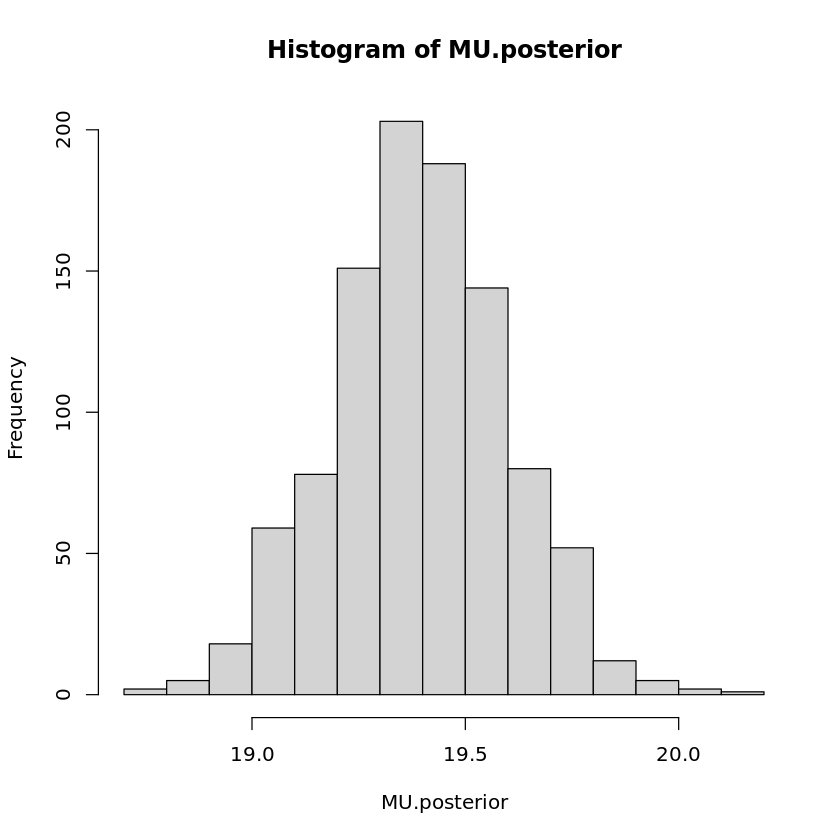

In [19]:
# We can tell the mesh isn't quite fine enough, because the triangle
# vertices are occasionally visible in the map (especially bottom right)
# I'm not actually sure if this will make much of a difference for
# predicting large area averages, but better safe...

# Collapse these samples to get an estimate for the whole MU
MU.posterior = colMeans(pred.samples^2, na.rm = T)
hist(MU.posterior) 
mean(MU.posterior)
sd(MU.posterior) # How well do the maps fit the data. [model, prior distributions and posterior distributions] 

[1] 34010

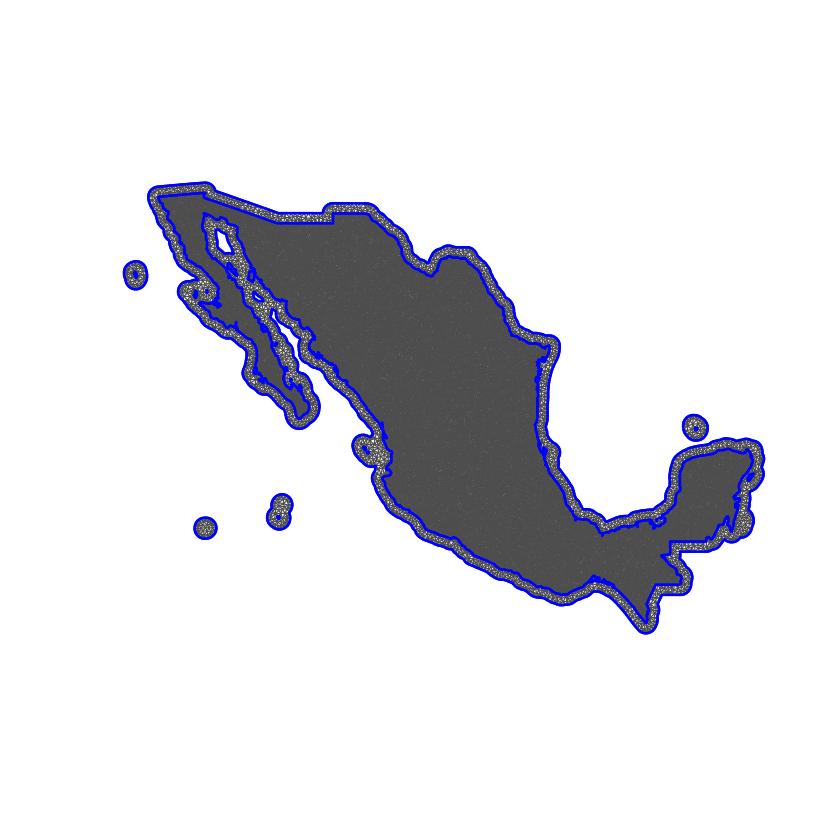

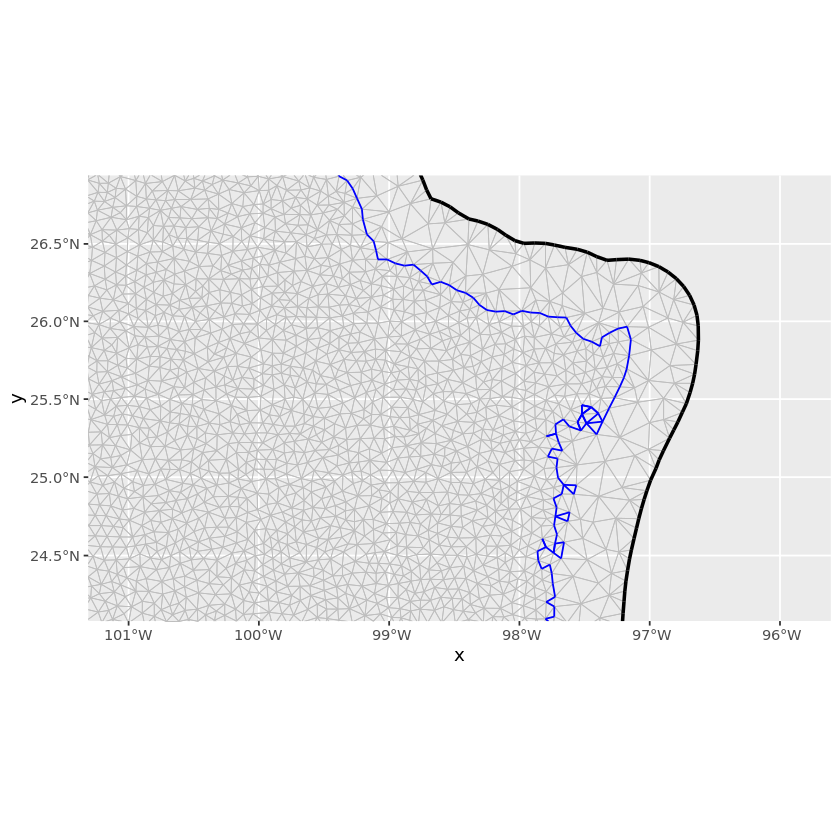

In [39]:
###################################
# Model refitting
###################################

# Often it's better to start with a coarser mesh and then refine it as needed.
# When you refit the model with the finer mesh, you don't need to start 
# the model fitting from square one. You can give INLA the final parameter 
# values from the previous fit as a starting value, which should speed things up.

# Below is the same as the above model fitting, but with a finer mesh.

# Max edge of 10 kilometers, this time.
max.edge = 10*10^3


mexico.buffer = st_buffer(mexico, dist = max.edge*5)

mesh = inla.mesh.2d(boundary = list(as(mexico, "Spatial"), as(mexico.buffer, "Spatial")),
                    max.edge = c(max.edge, 3*max.edge),
                    cutoff = 2*max.edge/3,
                    offset = c(max.edge, 5*max.edge))


# Many more vertices, this time
k = mesh$n
k
plot(mesh)
ggplot() + inlabru::gg(data = mesh) + coord_sf(crs = 6933, xlim = c(-9.75*10^6, -9.25*10^6), ylim = c(3*10^6, 3.3*10^6))

In [40]:
# Priors. These are the same Priors for the varying intercept
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5))

# # Priors for the varying coefficient
# spde.theta = inla.spde2.pcmatern(mesh, 
#                                 prior.range = c(30*10^3, 0.01), # Same interpretations here
#                                 prior.sigma = c(1, 0.5))

# Priors for the varying coefficient
spde.eta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5))


A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot)

# formula
formula = agbd ~
  -1 + intercept + 
  cci +
  # l4b +
  hei +
  f(alpha.spat, model = spde.alpha) + #... plus a spde for the spatial alpha
  f(beta.spat, model = spde.beta) +
  # f(theta.spat, model = spde.theta) +
  f(eta.spat, model = spde.eta)

# stack
stack = inla.stack(data = list(agbd = agbd.plot),
                   A = list(1,
                            1,
                            # 1,
                            1,
                            A.plot,
                            Diagonal(x = cci.plot)%*%A.plot,
                            # Diagonal(x = l4b.plot)%*%A.plot,
                            Diagonal(x = hei.plot)%*%A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     cci = cci.plot,
                     # l4b = l4b.plot,
                     hei = hei.plot,
                     alpha.spat = 1:k, # The random effects just need to given unique indices.
                     beta.spat = 1:k, # The random effects just need to given unique indices.
                     # theta.spat = 1:k,
                     eta.spat = 1:k
                   ))

# Fit this thing. Notice the arguments in 'control.mode = '
# We tell it the starting parameters in theta = 
# but tell it to restart the optimization from there (restart = T),
# and not just settle at these values
# Still will probably take a while, but less than it would have...

model_fit_v2 = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"),
                 control.mode = list(theta = model_fit$mode$theta, restart = T),
                 verbose = T)
summary(model_fit_v2)
hist(model_fit_v2$cpo$pit)
print(sum(log(model_fit_v2$cpo$cpo)))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': object 'model_fit_v2' not found



Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

[1] -24177.32


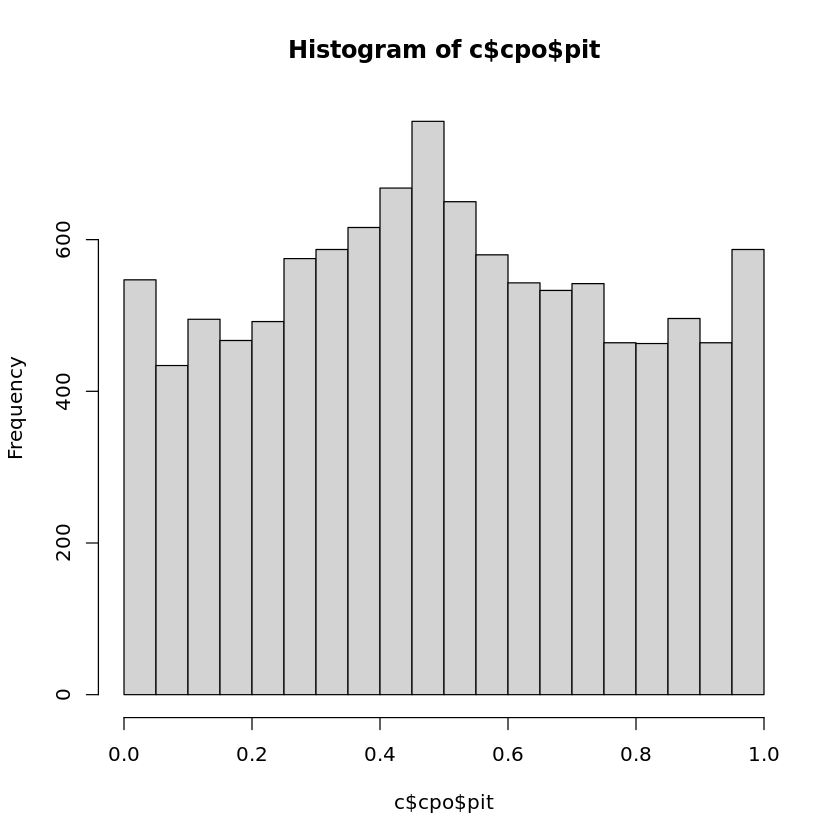

In [42]:
summary(c)
hist(c$cpo$pit)
print(sum(log(c$cpo$cpo)))

In [46]:
samples = inla.posterior.sample(n = 250, result = model_fit,
                                selection = list(intercept = 1,
                                                 alpha.spat = 1:k))

ERROR: Error in inla.posterior.sample.interpret.selection(selection, result): all(sel <= len) is not TRUE


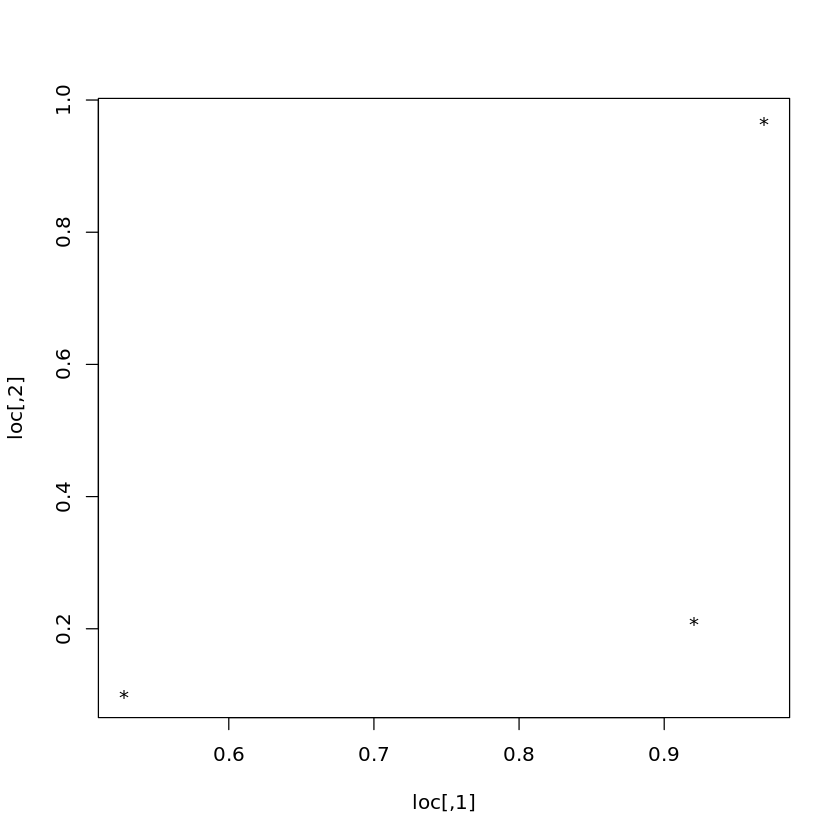

ERROR: Error in reg2theta(c(sigma, range)): could not find function "reg2theta"


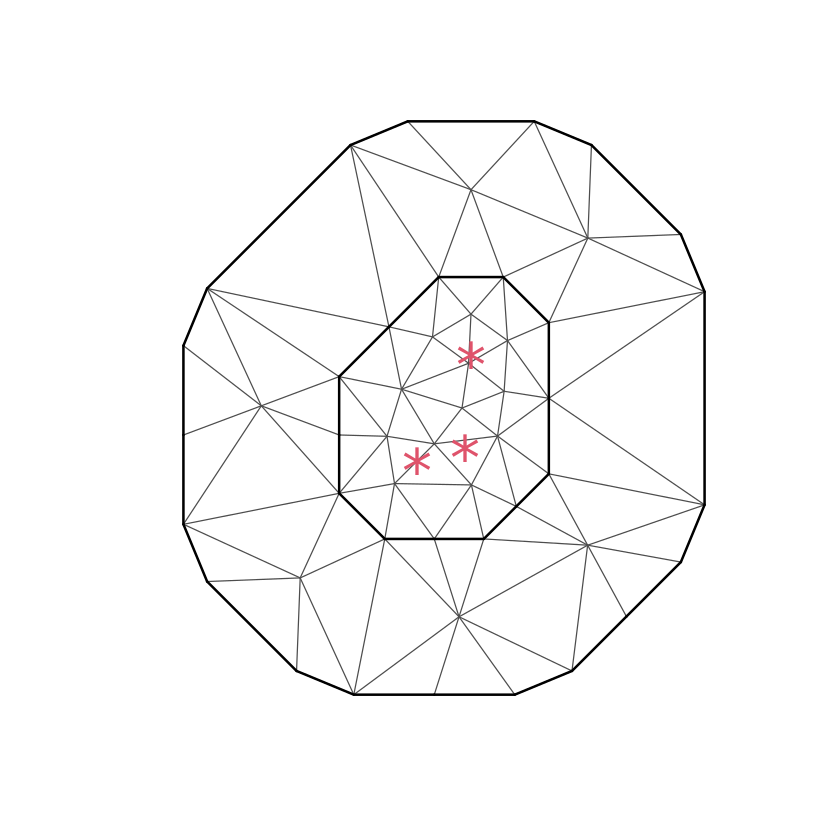

In [2]:
library(INLA)
library(Matrix)

# source("./scripts/functions/typSpatial.R")

set.seed(96)

n = 3

loc = cbind(runif(n), runif(n))

plot(loc, pch = '*')

sigma = 1
range = 0.7

me = range/1.1
mesh = inla.mesh.2d(loc.domain = loc,
                    max.edge = c(me, 100*me),
                    offset = c(me, me*2),
                    cutoff = me/2)

plot(mesh)
points(loc, pch ='*', col = 2,cex=3)

spde = inla.spde2.matern(mesh)

Q = inla.spde2.precision(spde, theta = reg2theta(c(sigma, range)))

w = inla.qsample(Q = Q)

library(inlabru)
library(ggplot2)
library(viridis)


ggplot() + gg(mesh) +
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = c(w))) +
  scale_color_viridis()

A = inla.spde.make.A(mesh, loc)

ggplot() + gg(mesh) +
  geom_point(aes(x = loc[,1], y = loc[,2], col = drop(A%*%w) )) +
  scale_color_viridis()


# Distribution of w | y

# w ~ MVN(0, Q^{-1})


# p(\theta | data) = f(data | \theta)*\pi(\theta)

# w | y MVN(   
#  (Q(sigma, range)  + A^TA/tau^2))

In [4]:
A = inla.spde.make.A(mesh, loc)
dim(A)
A

[1]  3 50

3 x 50 sparse Matrix of class "dgCMatrix"
                                                                        
[1,] . . . . . . . . . . . . . 0.5660989 .         . .         0.4339011
[2,] . . . . . . . . . . . . . .         0.8021299 . .         .        
[3,] . . . . . . . . . . . . . 0.4455126 .         . 0.3909766 .        
                                                                              
[1,] .         9.620261e-16 .         .          . . . . . . . . . . . . . . .
[2,] .         .            0.1452219 0.05264824 . . . . . . . . . . . . . . .
[3,] 0.1635108 .            .         .          . . . . . . . . . . . . . . .
                              
[1,] . . . . . . . . . . . . .
[2,] . . . . . . . . . . . . .
[3,] . . . . . . . . . . . . .

In [7]:
Diagonal(x = 10^(3:1))

3 x 3 diagonal matrix of class "ddiMatrix"
     [,1] [,2] [,3]
[1,] 1000    .    .
[2,]    .  100    .
[3,]    .    .   10

In [10]:
m <- matrix(1:6, nrow=2)
m

[,1] [,2] [,3]
[1,] 1    3    5   
[2,] 2    4    6

In [12]:
m%*%A

2 x 50 Matrix of class "dgeMatrix"
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
[1,]    0    0    0    0    0    0    0    0    0     0     0     0     0
[2,]    0    0    0    0    0    0    0    0    0     0     0     0     0
        [,14]   [,15] [,16]    [,17]     [,18]     [,19]        [,20]     [,21]
[1,] 2.793662 2.40639     0 1.954883 0.4339011 0.8175541 9.620261e-16 0.4356656
[2,] 3.805273 3.20852     0 2.345860 0.8678022 0.9810649 1.924052e-15 0.5808875
         [,22] [,23] [,24] [,25] [,26] [,27] [,28] [,29] [,30] [,31] [,32]
[1,] 0.1579447     0     0     0     0     0     0     0     0     0     0
[2,] 0.2105929     0     0     0     0     0     0     0     0     0     0
     [,33] [,34] [,35] [,36] [,37] [,38] [,39] [,40] [,41] [,42] [,43] [,44]
[1,]     0     0     0     0     0     0     0     0     0     0     0     0
[2,]     0     0     0     0     0     0     0     0     0     0     0     0
     [,45] [,46] [,47] [,48] [,49] [,50]
[1,]  

In [30]:
f=c(1,2.6,3.9,4)
mean(f)
sd(f)

df <- data.frame(matrix(unlist(f), nrow=length(f), byrow=TRUE))
apply(df,2,sd)

[1] 2.875

[1] 1.40327

matrix.unlist.f...nrow...length.f...byrow...TRUE. 
                                          1.40327

In [25]:
r=sqrt(sum(c((1-mean(f))^2,(2.6-mean(f))^2,(3.9-mean(f))^2,(4-mean(f))^2)/3))
r

[1] 1.40327